In [1]:
import shap
import joblib
import warnings
import pandas as pd
import seaborn as sns
from pdpbox import pdp
from sklearn.svm import SVC
from sklearn import set_config
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from utilities.evaluation import ModelEvaluation
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

set_config(display='diagram')

pd.set_option('float_format', '{:.2f}'.format)
warnings.filterwarnings(action='ignore')

In [2]:
churn = pd.read_csv('../data/churn-modeling.csv', sep=';')
churn.sample(n=4)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
2384,15758531,Y?,732,France,Female,40,10,0.00,2,Yes,No,154189.08,0
4339,15605293,McKay,559,France,Female,43,1,0.00,2,Yes,Yes,196645.87,0
1582,15631072,Huie,690,France,Male,38,1,94456.00,2,No,Yes,55034.02,0
1111,15798424,Glover,833,Germany,Male,59,1,130854.59,1,Yes,Yes,30722.52,1


## Validación cruzada

In [3]:
exited = churn.pop('Exited')

train_data, test_data, train_label, test_label = train_test_split(churn, exited,
                                                                  test_size=0.3,
                                                                  stratify=exited, random_state=42)

print(f'El set de entrenamiento tiene {train_data.shape[0]} observaciones, y {train_data.shape[1]} variables.')
print(f'El set de prueba tiene {test_data.shape[0]} observaciones, y {test_data.shape[1]} variables.')

El set de entrenamiento tiene 7000 observaciones, y 12 variables.
El set de prueba tiene 3000 observaciones, y 12 variables.


In [4]:
numerical_features = ['CreditScore', 'Age', 'Tenure',
                      'Balance', 'NumOfProducts', 'EstimatedSalary']

categorical_features = ['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']

In [5]:
numeric_preprocessing = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                        ('scaler', StandardScaler())])

categoric_preprocessing = Pipeline(steps=[('cat_imputer', SimpleImputer(strategy='most_frequent')),
                                          ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

preprocessing = ColumnTransformer(transformers=[('numeric', numeric_preprocessing, numerical_features),
                                                ('categorical', categoric_preprocessing, categorical_features)],
                                  remainder='drop')

In [6]:
lr = Pipeline(steps=[('preprocessing', preprocessing),
                     ('logistic_regression', LogisticRegression(penalty='l1', solver='saga',
                                                                class_weight='balanced', random_state=42, n_jobs=-1))])

dtree = Pipeline(steps=[('preprocessing', preprocessing),
                        ('dtree', DecisionTreeClassifier(max_depth=4,
                                                         class_weight='balanced', random_state=42))])

svm = Pipeline(steps=[('preprocessing', preprocessing),
                      ('svm', SVC(probability=True,
                                  class_weight='balanced', random_state=42))])

In [7]:
roc = {}
f1_score = {}

roc['logistic_regression'] = cross_val_score(estimator=lr,
                                             X=train_data, y=train_label, scoring='roc_auc', cv=5, n_jobs=-1)
roc['decision_tree'] = cross_val_score(estimator=dtree,
                                       X=train_data, y=train_label, scoring='roc_auc', cv=5, n_jobs=-1)
roc['svm'] = cross_val_score(estimator=svm,
                             X=train_data, y=train_label, scoring='roc_auc', cv=5, n_jobs=-1)

# --------------------------------------------------------------------------------------------------------------

f1_score['logistic_regression'] = cross_val_score(estimator=lr,
                                                  X=train_data, y=train_label, scoring='f1', cv=5, n_jobs=-1)
f1_score['decision_tree'] = cross_val_score(estimator=dtree,
                                            X=train_data, y=train_label, scoring='f1', cv=5, n_jobs=-1)
f1_score['svm'] = cross_val_score(estimator=svm,
                                  X=train_data, y=train_label, scoring='f1', cv=5, n_jobs=-1)

In [8]:
roc = pd.DataFrame.from_dict(roc)
f1_score = pd.DataFrame.from_dict(f1_score)

In [9]:
valor_medio = pd.concat(objs=[pd.DataFrame(roc.mean(), columns=['roc_auc']),
                              pd.DataFrame(f1_score.mean(), columns=['f1_score'])], axis=1)

In [10]:
std = pd.concat(objs=[pd.DataFrame(roc.std(), columns=['roc_auc_std']),
                      pd.DataFrame(f1_score.std(), columns=['f1_score_std'])], axis=1)

In [11]:
resultados = pd.concat(objs=[valor_medio, std], axis=1)
resultados

,roc_auc,f1_score,roc_auc_std,f1_score_std
logistic_regression,0.76,0.48,0.02,0.01
decision_tree,0.81,0.52,0.01,0.01
svm,0.85,0.58,0.01,0.01


In [12]:
lr.fit(train_data, train_label)
dtree.fit(train_data, train_label)
svm.fit(train_data, train_label)

predictions = {}

predictions['lr'] = cross_val_predict(estimator=lr,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method='predict_proba')[:, 1]

predictions['dtree'] = cross_val_predict(estimator=dtree,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method='predict_proba')[:, 1]

predictions['svm'] = cross_val_predict(estimator=svm,
                                      X=test_data, y=test_label, cv=5, n_jobs=-1, method='predict_proba')[:, 1]

predictions = pd.DataFrame.from_dict(predictions)

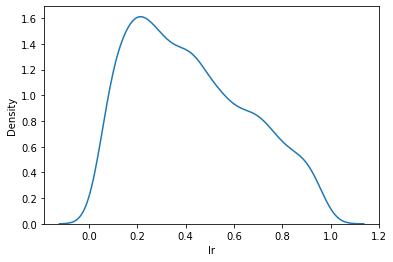

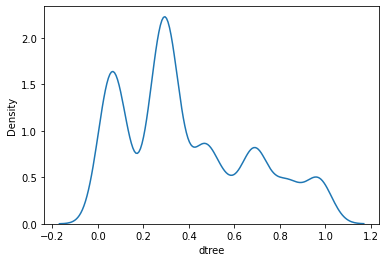

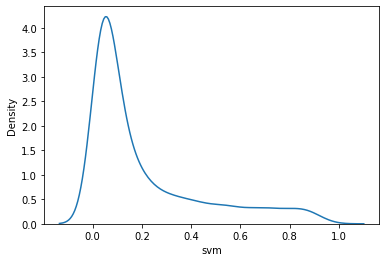

In [13]:
for col in predictions.columns:
    sns.distplot(predictions[col], hist=False)
    plt.show()

In [14]:
evaluation = ModelEvaluation(observed=test_label, predicted=svm.predict(test_data))
evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix(normalize=False)

El AUC es: 0.79
El accuracy es: 0.8
La precision es: 0.84
El recall es: 0.8
El F1 Score es: 0.81 



Predicted,0,1
Observed,,
0,1921,468
1,141,470


In [15]:
svm['svm']

SVC(class_weight='balanced', probability=True, random_state=42)

In [16]:
params = svm['svm'].get_params()
params

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': 'balanced',
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [17]:
joblib.dump(svm, filename='models/svm.joblib')
svm = None

In [18]:
svm = joblib.load(filename='models/svm.joblib')
svm

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Gender', 'Geography',
                                                   'HasCrCard',
                                                   'IsActiveMember'])])),
                ('svm',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [19]:
lr = Pipeline(steps=[('preprocessing', preprocessing),
                     ('logistic_regression', LogisticRegression(penalty='l1', solver='saga',
                                                                class_weight='balanced', random_state=42, n_jobs=-1))])

dtree = Pipeline(steps=[('preprocessing', preprocessing),
                        ('dtree', DecisionTreeClassifier(max_depth=4,
                                                         class_weight='balanced', random_state=42))])

svm = Pipeline(steps=[('preprocessing', preprocessing),
                      ('svm', SVC(probability=True,
                                  class_weight='balanced', random_state=42))])

ensemble = VotingClassifier(estimators=[('lr', lr),
                                        ('dtree', dtree),
                                        ('svm', svm)],
                            weights=[1, 1, 2], voting='soft', n_jobs=-1)

ensemble.fit(train_data, train_label)

VotingClassifier(estimators=[('lr',
                              Pipeline(steps=[('preprocessing',
                                               ColumnTransformer(transformers=[('numeric',
                                                                                Pipeline(steps=[('imputer',
                                                                                                 SimpleImputer(strategy='median')),
                                                                                                ('scaler',
                                                                                                 StandardScaler())]),
                                                                                ['CreditScore',
                                                                                 'Age',
                                                                                 'Tenure',
                                                                                 'Balance',
                                                                                 'NumOfProducts',
                                                                                 'EstimatedSalary']),
                                                                               ('categorical',
                                                                                Pipeline(steps=[('cat_imputer',
                                                                                                 SimpleImputer(strategy='mo...
                                                                                 'NumOfProducts',
                                                                                 'EstimatedSalary']),
                                                                               ('categorical',
                                                                                Pipeline(steps=[('cat_imputer',
                                                                                                 SimpleImputer(strategy='most_frequent')),
                                                                                                ('ohe',
                                                                                                 OneHotEncoder(handle_unknown='ignore',
                                                                                                               sparse=False))]),
                                                                                ['Gender',
                                                                                 'Geography',
                                                                                 'HasCrCard',
                                                                                 'IsActiveMember'])])),
                                              ('svm',
                                               SVC(class_weight='balanced',
                                                   probability=True,
                                                   random_state=42))]))],
                 n_jobs=-1, voting='soft', weights=[1, 1, 2])

In [20]:
evaluation = ModelEvaluation(observed=test_label, predicted=ensemble.predict(test_data))
evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix(normalize=False)

El AUC es: 0.76
El accuracy es: 0.85
La precision es: 0.85
El recall es: 0.85
El F1 Score es: 0.85 



Predicted,0,1
Observed,,
0,2184,205
1,239,372


## XGboosting

In [21]:
from collections import Counter
counter = Counter(train_label)
counter[0]/counter[1]

3.908835904628331

In [22]:
xgb = Pipeline(steps=[('preprocessing', preprocessing),
                      ('xgbbost', XGBClassifier(max_depth=4, scale_pos_weight=3.9,
                                                learning_rate=0.08, subsample=0.7, random_state=42))])

xgb.fit(train_data, train_label)

[21:09:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts',
                                                   'EstimatedSalary']),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.08,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, random_state=42,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=3.9,
                               subsample=0.7, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

In [23]:
evaluation = ModelEvaluation(observed=test_label, predicted=xgb.predict(test_data))
evaluation.calculate_metrics()
evaluation.print_metrics()
evaluation.confusion_matrix(normalize=False)

El AUC es: 0.79
El accuracy es: 0.81
La precision es: 0.85
El recall es: 0.81
El F1 Score es: 0.82 



Predicted,0,1
Observed,,
0,1965,424
1,145,466


In [24]:
test_data.sample(3)

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
1908,15626983,Ledford,605,Spain,Female,48,6,0.00,2,Yes,Yes,40062.99
2860,15705890,Nebechukwu,674,France,Male,45,7,142072.02,1,Yes,No,37013.29
9177,15770548,Lucchese,453,Germany,Female,28,3,139986.65,1,Yes,No,136846.75


In [25]:
categorical_features

['Gender', 'Geography', 'HasCrCard', 'IsActiveMember']

In [26]:
numerical_features

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [27]:
features = xgb.named_steps.preprocessing.named_transformers_['categorical']['ohe'].get_feature_names()

ohe_features = []

for feature in features:
    if feature.split('_')[0] == 'x2':
        ohe_features.append(f'CrCard_{feature.split("_")[1]}')
    elif feature.split('_')[0] == 'x3':
        ohe_features.append(f'ActiveMember_{feature.split("_")[1]}')
    else:
        ohe_features.append(feature.split("_")[1])

ohe_features

['Female',
 'Male',
 'France',
 'Germany',
 'Spain',
 'CrCard_No',
 'CrCard_Yes',
 'ActiveMember_No',
 'ActiveMember_Yes']

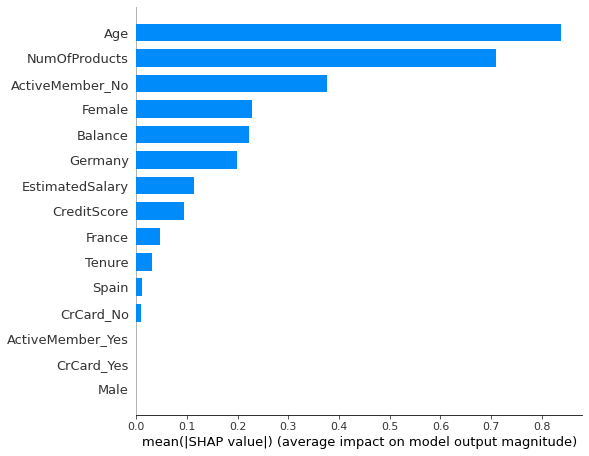

In [28]:
X = pd.DataFrame(xgb['preprocessing'].transform(test_data), columns=numerical_features + ohe_features)
model = xgb['xgbbost']

explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X=X)
shap.summary_plot(shap_values, X, plot_type='bar')

In [29]:
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Female,Male,France,Germany,Spain,CrCard_No,CrCard_Yes,ActiveMember_No,ActiveMember_Yes
0,1.44,-0.19,0.34,-1.22,0.80,0.35,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00
1,-1.34,-0.38,0.34,0.32,-0.91,-1.55,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
2,0.64,-0.19,-1.39,0.49,0.80,1.22,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00
3,0.81,-0.09,1.73,-1.22,0.80,1.57,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00
4,0.46,1.23,1.03,0.43,-0.91,-1.34,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.91,2.65,-1.39,0.87,-0.91,-1.34,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
2996,-0.24,-0.38,0.69,-1.22,-0.91,1.54,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00
2997,-1.55,0.09,-0.00,0.61,-0.91,0.47,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
2998,1.47,-0.95,-0.35,0.50,-0.91,-1.40,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00


In [30]:
X[numerical_features] = xgb.named_steps.preprocessing.named_transformers_['numeric']['scaler'].inverse_transform(X[numerical_features])
X

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Female,Male,France,Germany,Spain,CrCard_No,CrCard_Yes,ActiveMember_No,ActiveMember_Yes
0,790.00,37.00,6.00,0.00,2.00,119484.01,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00
1,521.00,35.00,6.00,96423.84,1.00,10488.44,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
2,712.00,37.00,1.00,106881.50,2.00,169386.81,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,0.00
3,729.00,38.00,10.00,0.00,2.00,189727.12,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00
4,695.00,52.00,8.00,103023.26,1.00,22485.64,0.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,738.00,67.00,1.00,130652.52,1.00,22762.23,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00
2996,627.00,35.00,7.00,0.00,1.00,187718.26,1.00,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00
2997,501.00,40.00,5.00,114655.58,1.00,126535.92,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
2998,792.00,29.00,4.00,107601.79,1.00,18922.18,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00


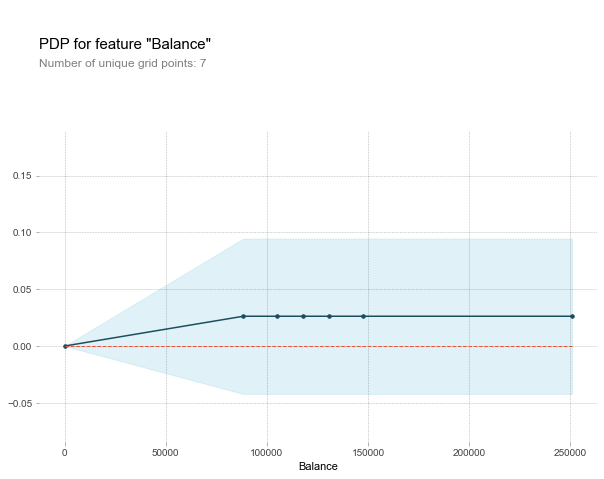

In [31]:
pdp_df = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns, feature='Balance')
pdp.pdp_plot(pdp_df, 'Balance', figsize=(10, 8))
plt.show()

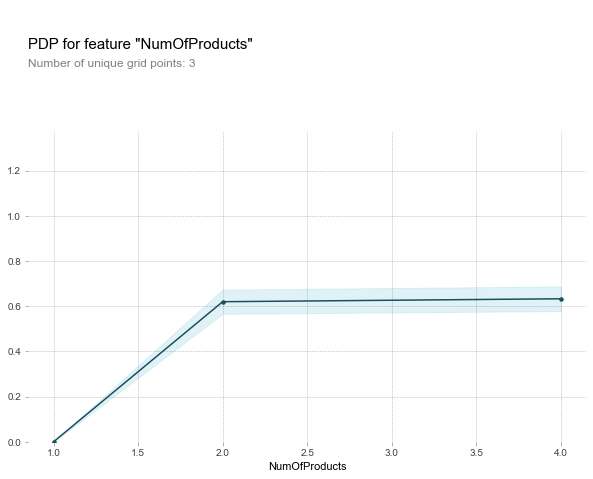

In [32]:
pdp_df = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns, feature='NumOfProducts')
pdp.pdp_plot(pdp_df, 'NumOfProducts', figsize=(10, 8))
plt.show()

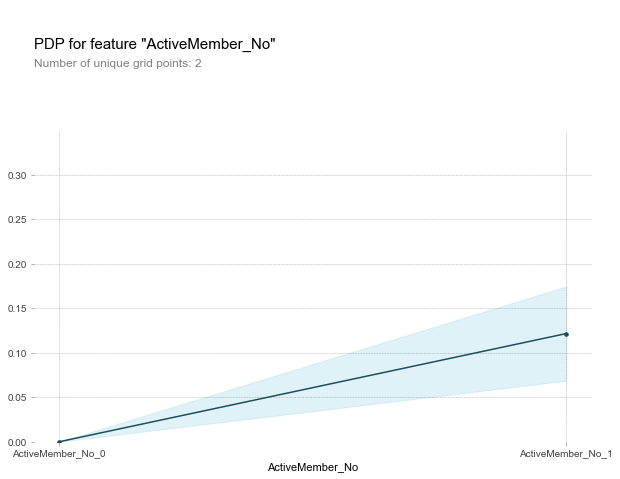

In [33]:
pdp_df = pdp.pdp_isolate(model=model, dataset=X, model_features=X.columns, feature='ActiveMember_No')
pdp.pdp_plot(pdp_df, 'ActiveMember_No', figsize=(10, 8))
plt.show()

## Paso por paso (Fuera de un Pipeline)

In [34]:
X_train, X_test, y_train, y_test = train_data.copy(), test_data.copy(), train_label.copy(), test_label.copy()

In [35]:
imputer_num = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_train[numerical_features] = imputer_num.fit_transform(X_train[numerical_features])
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])

imputer_cat = SimpleImputer(strategy='most_frequent')
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

X_train[categorical_features] = imputer_cat.fit_transform(X_train[categorical_features])
ohe_df = pd.DataFrame(ohe.fit_transform(X_train[categorical_features]), columns=ohe.get_feature_names())

X_train.drop(categorical_features, axis=1, inplace=True)
X_train = pd.concat([X_train.reset_index(drop=True), ohe_df], axis=1)
X_train

,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,x0_Female,x0_Male,x1_France,x1_Germany,x1_Spain,x2_No,x2_Yes,x3_No,x3_Yes
0,15688984,Belonwu,-0.58,-1.80,-0.35,0.31,-0.91,1.36,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
1,15762351,Chao,0.40,2.27,-1.39,-1.22,0.80,1.52,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00
2,15814209,Capon,1.69,-0.76,-1.39,0.68,-0.91,0.04,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
3,15637593,Greco,0.74,-1.80,0.34,-1.22,0.80,1.67,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00
4,15657439,Chao,0.91,-1.99,-0.35,-1.22,0.80,-0.90,0.00,1.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,15681843,Barbour,-0.28,-0.38,-1.73,1.67,0.80,1.12,1.00,0.00,0.00,1.00,0.00,0.00,1.00,1.00,0.00
6996,15714240,Ponomarev,0.64,3.31,-0.00,-1.22,0.80,0.90,0.00,1.00,0.00,0.00,1.00,1.00,0.00,1.00,0.00
6997,15709780,Azuka,0.17,-0.19,1.38,-0.07,0.80,-0.55,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
6998,15689425,Olejuru,0.38,-0.38,1.03,0.40,0.80,-1.34,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00


In [36]:
print(scaler.mean_)
print(scaler.scale_)

[6.50562429e+02 3.89984286e+01 5.01057143e+00 7.63144623e+04
 1.53300000e+00 9.94663160e+04]
[9.65325605e+01 1.05741935e+01 2.89169297e+00 6.23701186e+04
 5.84120462e-01 5.74473074e+04]


In [37]:
X_test[numerical_features] = imputer_num.transform(X_test[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [38]:
print(scaler.mean_)
print(scaler.scale_)

[6.50562429e+02 3.89984286e+01 5.01057143e+00 7.63144623e+04
 1.53300000e+00 9.94663160e+04]
[9.65325605e+01 1.05741935e+01 2.89169297e+00 6.23701186e+04
 5.84120462e-01 5.74473074e+04]


In [40]:

train_data[numerical_features] = imputer_num.fit_transform(train_data[numerical_features])
train_data[numerical_features] = scaler.fit_transform(train_data[numerical_features])

print(scaler.mean_)
print(scaler.scale_)

[6.50562429e+02 3.89984286e+01 5.01057143e+00 7.63144623e+04
 1.53300000e+00 9.94663160e+04]
[9.65325605e+01 1.05741935e+01 2.89169297e+00 6.23701186e+04
 5.84120462e-01 5.74473074e+04]


In [41]:
test_data[numerical_features] = imputer_num.fit_transform(test_data[numerical_features])
test_data[numerical_features] = scaler.fit_transform(test_data[numerical_features])

print(scaler.mean_)
print(scaler.scale_)

[6.50450333e+02 3.87430000e+01 5.01800000e+00 7.68858857e+04
 1.52366667e+00 1.01546062e+05]
[9.69183275e+01 1.02794107e+01 2.89280879e+00 6.24488077e+04
 5.75708163e-01 5.76218282e+04]
